In [4]:
using IJulia, Plots, Printf

# Steady 1D Shallow Water equations

The purpose of this jupyter notebook is to provide a public and free usable stable implementation of the solution of the steady 1D SWE, first adopting a fixed bad approach and then moving to the mobile bed.

## Problem definition
First of all the definition of the problem is required, as well as the equations that will be solved.  
The problem consists in a (wide) rectangular channel, that can present steps, gates, localized narrowing or whatever along its longitudinal direction. The same solution could be performed for any prismatic channel, the choice of rectangular shape is done just for simplicity purposes. 
The situation in a section is depicted in the figure, at the same time the foundamental definitions referst to the image:  
  
![Problem description](images/problem_definition.svg)
  
The image shows a genelar section for which the following quantities are defined:
- d: water depth $[m]$;
- h: water level $[m]$;
- z: bed elevation (fixed) $[m]$;
- $kin:= \alpha \frac{U}{2g}$ $[m]$: the kinetic term of the energy;
- $H = h + kin$: the total Head (or Energy) $[m]$;
- $E = H - z = d + kin$: the Specific head (or Energy) $[m]$;
- $S = P_G \Omega + \rho \beta U^2 \Omega$: the Specific force [$N/m^2$].
  
Here $P_G$ is the pressure at the barycenter of the section, $\Omega$ is the cross-sectional area and $U$ the mean velocity all over the section.  



## The energy equations
As anticipated, the problem is solved through the energy equations, obtained from the momentum equation moltiplying them for the velocity $U$, and assuming the steady state. The equations reads as follows:  
$\frac{dh}{dx} = \frac{\beta \frac{F_r^2}{B} \frac{\partial \Omega}{\partial x}|_h - j}{1+\beta F_r^2}$  
  
$\frac{dd}{dx} = \frac{\beta \frac{F_r^2}{B} \frac{\partial \Omega}{\partial x}|_d + i_F - j}{1+\beta F_r^2}$  
  
$\frac{dH}{dx} = - j$  

$\frac{dE}{dx} = i_F - j$  
  
The new terms needs a brief explanation: $j$ is the friction term, which is defined as $j = \frac{\tau _0}{\rho g R_H}$, it contains the friction $\tau _0$, the water density $\rho$, the gravity term $g$, and the hydraulic radius $R_H = \Omega / P$, with $P$ the wetted perimeter. The term $\frac{\partial \Omega}{\partial x}|_h$ is related to the non prismaticity of the channel, describe how the wetted area changes according to the geometry. This last term is zero in case of completely rectangular channel, in any case for fixed geometry it is just a coefficient that can be precompute and just considered into the equations. Since the equation will be solved for rectangular channel further simplification may be performed, to do not loose generality it will not, the coefficient accounting for the section irregularity will just setted properly.

### Considerations before implementing everything
The codes are provided in Julia. It is important to know that any numerical method for solving ODE could be implemented, in this case some manipulations and considerations are adopted for speed in the computations, that is one of the objectivies of this work.  
The steps for the implementations are the following:
1) Build the geometry and define the $dx$;
2) Solve the Energy ODE to obtain an Energy profile along the river;
3) Calculate the 2 normal depths for any section;
4) Calculate the Specific Force $S$ for both the depths for each section;
5) Assign the depth with the greatest $S$ between the two (disxrimination between fast/slow flows).
6) Include local discontinuities. 

Number of points in channel 1 is 1001
Uniform depths: [0.4097465823088311] m, Critical depths: [0.7415327354153678] m
first and last x coordinates: 0.0 m, 1000.0 m
first and last z coordinates: 50.0 m, 0.0 m
Left downward Energy = 1.6240586434363806 m, Right downward Energy = 1.6239786353802006 m
Left upward Energy = 1.6240586434363806 m, Right upward Energy = 1.6239786353802006 m
Spinta for the supercritical depths: 529283.2740093857 N/m, with depth: 0.4097454472145886 m
Spinta for the subcritical depths: 710009.6725289496 N/m, with depth: 1.537769353063854 m
Minimum Spinta: 405886.78571428574 N/m at depth: 0.7 m
Spinta at d_fast_1: 461312.5 N/m, at depth: 0.5 m
Spinta at d_slow_1: 405886.78571428574 N/m, at depth: 0.7 m


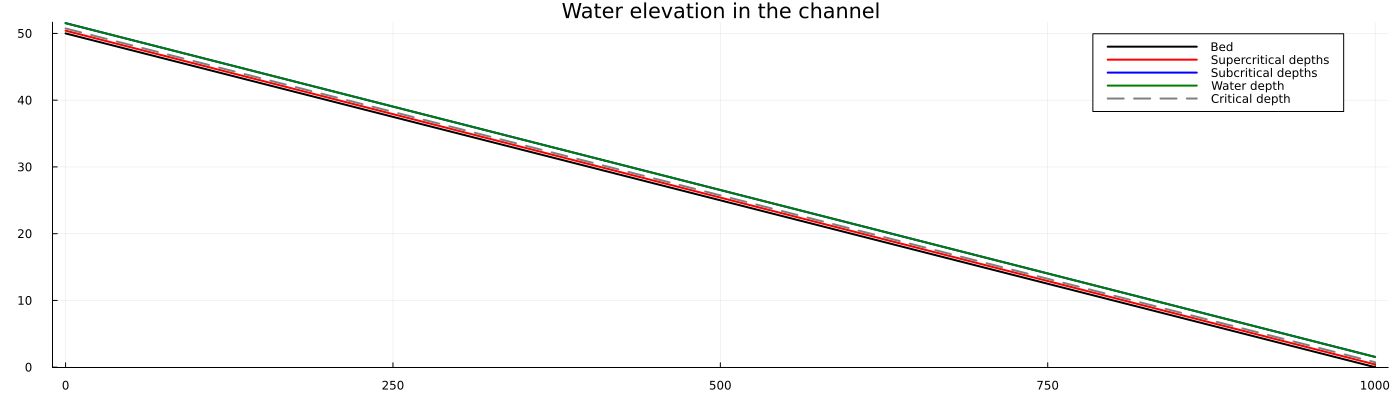

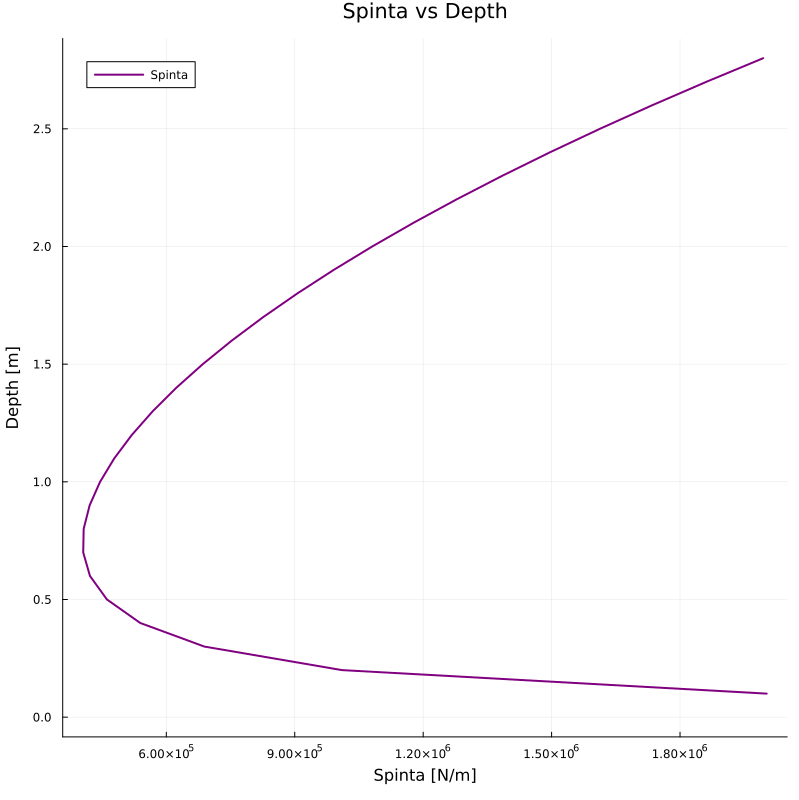

In [23]:
# Build the geometry and define the $dx$;

@views function evaluate_depths(Q, B, L, Ks, iF)
    # Find the normal depth from the formula above, it is an implicit formula, so adopt an iterative procedure:
    Qnew = 0.0; tol = 1.0e-4; res = 0.1; n = 0; d = 1.0; # initial guess for the depth [m]
    initial_res = Q - B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2);
    while abs(res) >= tol 
        Qnew = B * d * Ks * ((B * d)/(2*d + B))^(2/3) * iF^(1/2)
        res = Q - Qnew;
        increment = res/initial_res*0.1;
        if res > 0 # so the depth is too small
            d += increment; # increase the depth
        else
            d -= increment; # decrease the depth
        end
        n += 1
    end
    c = (Q^2/(9.81*B^2))^(1/3)
    return d, c
end #function

@views function build_bed!(z, x, dx, iF, n_points)
    # build the bed of the channel, the idea is to have always positive z coordinates, and locate
    # the zero of the x coordinate at the most upstream point of the channel
    dz_tot = x[end] * iF            # total z coordinate at the end of the channel, it is a linear function of x
    for n in 1:n_points
        z[n] = -iF * x[n] + dz_tot # z coordinate is a linear function of x, with slope iF
    end
    # return z
end

@views function E2d(d_c, Q, B, e; style)
    g = 9.81 # gravity acceleration [m/s^2]
    if style == "subcritical" 
        d = d_c + 1.0
        obj = d + Q^2 / (2 * g * (B * d)^2)
        initial_res = obj - e; res = initial_res
        while abs(obj - e) >=1.e-5
            obj = d + Q^2 / (2 * g * (B * d)^2)
            res = obj - e
            increment = res/initial_res*0.1
            if res > 0 # so the energy is too much
                d -= increment; # decrease the depth
            else
                d += increment; # increase the depth
            end
        end
    elseif style == "supercritical"
        d = d_c - 1.0
        obj = d + Q^2 / (2 * g * (B * d)^2)
        initial_res = obj - e; res = initial_res
        while abs(obj - e) >=1.e-5
            obj = d + Q^2 / (2 * g * (B * d)^2)
            res = obj - e
            increment = res/initial_res*0.1
            if res > 0 # so the energy is too much
                d += increment; # increase the depth
            else
                d -= increment; # decrease the depth
            end
        end
    else
        error("Style must be either 'subcritical' or 'supercritical'")
    end
    return d
end

Spinta(Q, B, d) = 500*9.81*B*d^2 + 1000*Q^2/(B*d)

L = [1000.0]        # length of the channel [m]
Q = 100.0            # discharge [m^3/s] Q = Ω Ks R^2/3 iF^1/2
B = [50.0]         # width of the channel [m]
Ks = 40.0           # Strickler coefficient [m^(1/3)/s] Ks = 1/n
iF = [0.05]        # slope of the channel
dx = 1.0           # distance between the points of the channel [m]
g = 9.81            # gravity acceleration [m/s^2]

n_segments = 1 # number of segments of the channel (with different slopes)
d_uniform  = Array{Float64}(undef, n_segments) # array to store the uniform depths
d_critical = Array{Float64}(undef, n_segments) # array to store the critical depths
X = Float64[] # x coordinates of the points in the channel
Z = Float64[] # z coordinates of the points in the channel
for n in 1:n_segments
    d_uniform[n], d_critical[n] = evaluate_depths(Q, B[n], L[n], Ks, iF[n])
    L[n]%dx ≠ 0 && error("The length of the channel must be a multiple of dx")
    n_points = Int(L[n]/dx) + 1         # number of points in the channel
    println("Number of points in channel ", n, " is ",  n_points)
    x = LinRange(0, L[n], n_points)                     # x coordinates of the points
    z = zeros(n_points)                 # z coordinates of the points, initially all zero
    build_bed!(z, x, dx, iF[n], n_points) # build the bed of the channel
    X = n == 1 ? x : [X, x]
    Z = n == 1 ? z : [Z, z] # concatenate the arrays for the first segment or the others
end
d_critical_vector = d_critical[1] * ones(length(X)) # vector of critical depths, same length as X

# The water elevation has no need to be initialized, just the two extreems values for the BC
# The BC are always the uniform flow depth:
α = 1.0 # correction factor for the non prismaticity of the channel
eL = d_uniform[1] + Q^2 / (2 * g * (B[1] * d_uniform[1])^2) # water elevation at the left boundary [begin]
eR = d_uniform[1] + Q^2 / (2 * g * (B[1] * d_uniform[1])^2) # water elevation at the left boundary [end]


println("Uniform depths: ", d_uniform, " m, Critical depths: ", d_critical, " m")
println("first and last x coordinates: ", X[begin], " m, ", X[end], " m")
println("first and last z coordinates: ", Z[begin], " m, ", Z[end], " m")

 
Npoints = length(X)
e_dw = zeros(Npoints) # energy E at the points of the channel
e_dw[1] = eL

# Solve the energy equation from left to right (downward)
for n in 2:Npoints
    # integration of the solution:
    Rh = (B[1] * d_uniform[1])/(2*d_uniform[1] + B[1])
    e_dw[n] = e_dw[n-1] - dx * (iF[1] - (Q/(Ks * B[1] * d_uniform[1]))^2 * Rh^(-4/3))
end
println("Left downward Energy = ", e_dw[1], " m, Right downward Energy = ", e_dw[Npoints], " m")

# Solve the energy equation from right to left (upward)
e_uw = zeros(Npoints) # energy E at the points of the channel
e_uw[Npoints] = eR
for n in Npoints-1:-1:1
    # integration of the solution:
    Rh = (B[1] * d_uniform[1])/(2*d_uniform[1] + B[1])
    e_uw[n] = e_uw[n+1] - dx * (iF[1] - (Q/(Ks * B[1] * d_uniform[1]))^2 * Rh^(-4/3))
end
println("Left upward Energy = ", e_dw[1], " m, Right upward Energy = ", e_dw[Npoints], " m")

# From the solution of the energy abstract two depths:
d_fast = zeros(Npoints) # depth from the downward energy
d_slow = zeros(Npoints) # depth from the upward energy   
for n = 1:Npoints
    # The depth is the energy minus the kinetic energy:
    d_fast[n] = E2d(d_critical[1], Q, B[1], e_dw[n], style="supercritical")
    d_slow[n] = E2d(d_critical[1], Q, B[1], e_uw[n], style="subcritical")
end

# evaluate the Spinta for both the supercritical and subcritical depths
Spinta_fast = zeros(Npoints) # Spinta for the supercritical depths  
Spinta_slow = zeros(Npoints) # Spinta for the subcritical depths
for n = 1:Npoints
    Spinta_fast[n] = Spinta(Q, B[1], d_fast[n]) # Spinta for the supercritical depths
    Spinta_slow[n] = Spinta(Q, B[1], d_slow[n]) # Spinta for the subcritical depths
end
println("Spinta for the supercritical depths: ", Spinta_fast[1], " N/m, with depth: ", d_fast[1], " m")
println("Spinta for the subcritical depths: ", Spinta_slow[1], " N/m, with depth: ", d_slow[1], " m")


# Chose the depth with the maximum Spinta between the two:
d = zeros(Npoints) # final depth to be plotted
for n = 1:Npoints
    if Spinta_fast[n] > Spinta_slow[n]
        d[n] = d_fast[n] # use the supercritical depth
    else
        d[n] = d_slow[n] # use the subcritical depth
    end
end

y_limits = (min(minimum(Z), minimum(e_dw)) - 0.05, max(maximum(Z), maximum(Z+e_dw)) + 0.05)
p1 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=y_limits, color="black", linewidth=2,
    size=(1400, 400))
p1 = plot!(X, Z + d_fast, label="Supercritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="red", linewidth=2)
p1 = plot!(X, Z + d_slow, label="Subcritical depths", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="blue", linewidth=2)
p1 = plot!(X, Z + d, label="Water depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="green", linewidth=2)
p1 = plot!(X, Z + d_critical_vector, label="Critical depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="gray", linewidth=2, linestyle=:dash)
display(p1)

#=
y_limits = (min(minimum(Z), minimum(e_dw)) - 0.05, max(maximum(Z), maximum(Z+e_dw)) + 0.05)
p2 = plot(X, Z, label="Bed", xlabel="x [m]", ylabel="z [m]", title="Bed of the channel", legend=:topright,
    grid=true, xlims=(X[begin]-10, X[end]+10), ylims=y_limits, color="black", linewidth=2,
    size=(1400, 400))
p2 = plot!(X, Z + d, label="Water depth", xlabel="x [m]", ylabel="z [m]",
    title="Water elevation in the channel", grid=true, color="green", linewidth=2)
=#

a = (0.0:0.1:2.8)
b = zeros(length(a)) # array to store the Spinta values
for n in 1:length(a)
    b[n] = Spinta(Q, B[1], a[n])
end
min_b = minimum(b); a_min = findall(b .== min_b) # find the minimum Spinta and its corresponding depth
println("Minimum Spinta: ", min_b, " N/m at depth: ", a[a_min[1]], " m")
println("Spinta at d_fast_1: ", b[6], " N/m, at depth: ", a[6], " m")
println("Spinta at d_slow_1: ", b[8], " N/m, at depth: ", a[8], " m")

p3 = plot(b, a, label="Spinta", ylabel="Depth [m]", xlabel="Spinta [N/m]", title="Spinta vs Depth",
    grid=true, color="purple", linewidth=2, size=(800, 800))


![Why so far it doesn't work properly](images/Spinta_energia.PNG)